In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV

def transform_data():
    path_to_ny_sales = '../datasets/nyc-property/nyc-rolling-sales.csv'
    sales_df = pd.read_csv(path_to_ny_sales)


    # First transformation
    columns_to_drop = [
        'Unnamed: 0',
        'TAX CLASS AT PRESENT',
        'ZIP CODE',
        'BLOCK',
        'LOT',
        'EASE-MENT',
        'BUILDING CLASS AT PRESENT',
        'TAX CLASS AT TIME OF SALE',
        'BUILDING CLASS AT TIME OF SALE',
        'BUILDING CLASS CATEGORY',
        'NEIGHBORHOOD',
        'ADDRESS',
        'APARTMENT NUMBER',
        'SALE DATE'
    ]
    sales_df = sales_df.drop(columns=columns_to_drop)

    # Second transformation
    columns_to_convert = [
        'LAND SQUARE FEET',
        'GROSS SQUARE FEET',
        'SALE PRICE',
        'YEAR BUILT'
    ]
    for column_name in columns_to_convert:
        sales_df[column_name] = pd.to_numeric(sales_df[column_name], errors='coerce')
        sales_df = sales_df.fillna(-1)

    # Third transformation 
    # hint: look at the check_building_type function defined below
    # hint 2: read the "apply" function's documentation: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
    sales_df['BUILDING TYPE'] = sales_df.apply(check_building_type, axis=1) 
    sales_df = pd.get_dummies(sales_df, columns=['BUILDING TYPE'])

    # Fourth transformation
    sales_df['BOROUGH'] = sales_df['BOROUGH'].map({
        1 : 'Manhattan',
        2 : 'Bronx',
        3 : 'Brooklyn',
        4 : 'Queens',
        5 : 'Staten Island',
    })
    
    # Drop records with absurdly low price values
    sales_df = sales_df[ sales_df['SALE PRICE'] > 1000]
    
    # Write the results to a csv
    return sales_df


# It's better to define functions at the top level, rather than as
# inner functions inside main
def check_building_type(row):
    if row['COMMERCIAL UNITS'] > 0 and row['RESIDENTIAL UNITS'] > 0:
        return "MIXED USE"
    elif row['COMMERCIAL UNITS'] > 0:
        return "COMMERCIAL"
    elif row['RESIDENTIAL UNITS']:
        return "RESIDENTIAL"
    else:
        return "UNKNOWN - NO UNITS"
    
    



In [7]:
transformed_data = transform_data()


In [8]:
transformed_data.describe()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,BUILDING TYPE_COMMERCIAL,BUILDING TYPE_MIXED USE,BUILDING TYPE_RESIDENTIAL,BUILDING TYPE_UNKNOWN - NO UNITS
count,58604.000000,58604.000000,58604.000000,5.860400e+04,5.860400e+04,58604.000000,5.860400e+04,58604.000000,58604.000000,58604.000000,58604.000000
mean,1.705583,0.163948,1.881169,2.379285e+03,2.229247e+03,1811.956146,1.524388e+06,0.021773,0.024896,0.659051,0.294280
std,14.172163,9.917320,17.404054,3.545480e+04,2.386362e+04,502.802463,1.244863e+07,0.145944,0.155809,0.474032,0.455722
min,0.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,0.000000,1.110000e+03,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,1920.000000,3.850000e+05,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,7.565000e+02,0.000000e+00,1940.000000,6.390865e+05,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,2.000000,2.500000e+03,1.836000e+03,1966.000000,1.097755e+06,0.000000,0.000000,1.000000,1.000000
max,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,2.210000e+09,1.000000,1.000000,1.000000,1.000000


In [9]:
def train_and_report(dataset, model):
    print(f'Training the {model} model')

    labels = dataset['BOROUGH']
    features = dataset.drop(labels='BOROUGH', axis=1)

    # RandomState so we always use the same test/train split.
    # Stratify to ensure the train/test buckets contain the same makeup of class values (not balanced, but 20% of each class is in the test set)
    training_data, test_data, training_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=50, stratify=labels)

    model.fit(training_data, training_labels)

    train_score = model.score(training_data, training_labels)
    test_score = model.score(test_data, test_labels)
    
    print("======== Reporting =========")

    print(f"train: {train_score}, test: {test_score}")
    
    predictions = model.predict(transformed_data.drop(columns='BOROUGH'))

    print("\nNumber of predictions by class")
    print(pd.DataFrame(predictions).value_counts())
    
    print("\nNumber of true labels by class")
    print(transformed_data['BOROUGH'].value_counts())
    
    print("\nConfusion Matrix (all data, not just train or test)")
    cm = confusion_matrix(transformed_data['BOROUGH'], predictions)
    name_labels = model.classes_
    sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels, fmt='g') # fmt='g' prevents scientific notation here
    plt.show()
    
    print("\nConfusion Matrix (Just training data)")
    cm = confusion_matrix(training_labels, model.predict(training_data))
    sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels, fmt='g') 
    plt.show()
    
    print("\nConfusion Matrix (Just test data)")
    cm = confusion_matrix(test_labels, model.predict(test_data))
    sn.heatmap(cm, annot=True, xticklabels=name_labels, yticklabels=name_labels, fmt='g') 
    plt.show()

    
    return model

Training the LogisticRegression(max_iter=100000) model
======== Reporting =========
train: 0.46377151632788005, test: 0.45525125842504904

Number of predictions by class
Manhattan        28225
Queens           26705
Brooklyn          3144
Staten Island      507
Bronx               23
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


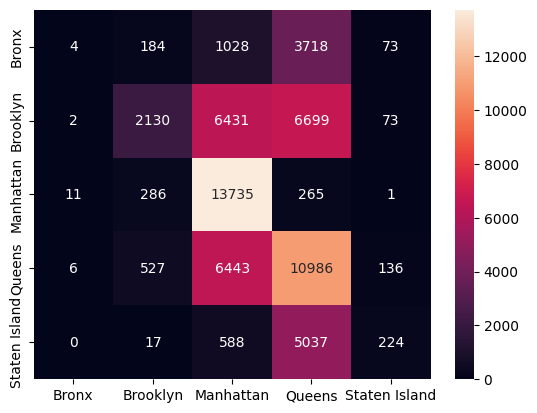


Confusion Matrix (Just training data)


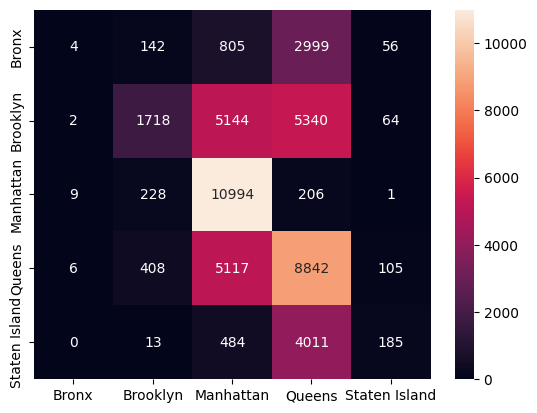


Confusion Matrix (Just test data)


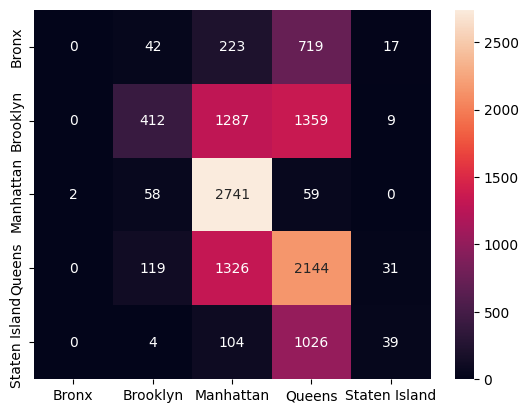

Training the LogisticRegression(max_iter=1000, multi_class='ovr') model
======== Reporting =========
train: 0.5053217584198963, test: 0.5031993857179422

Number of predictions by class
Queens           34873
Manhattan        20372
Brooklyn          2775
Staten Island      574
Bronx               10
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


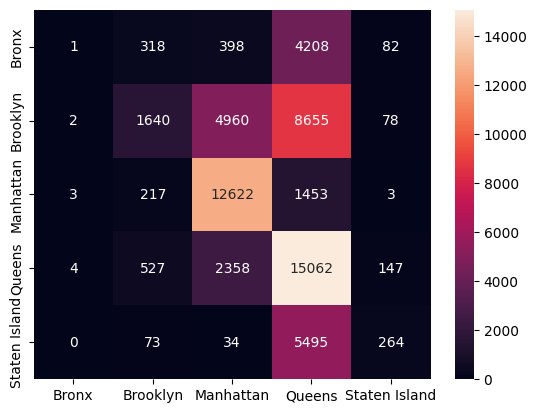


Confusion Matrix (Just training data)


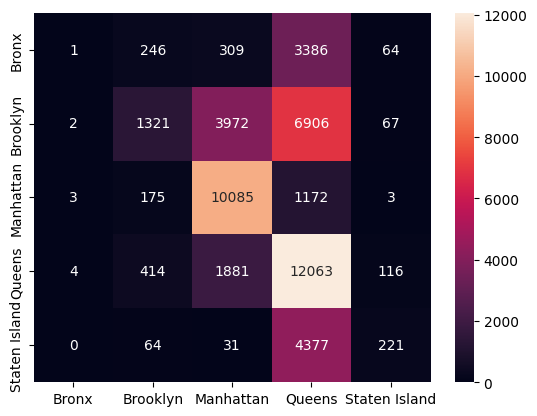


Confusion Matrix (Just test data)


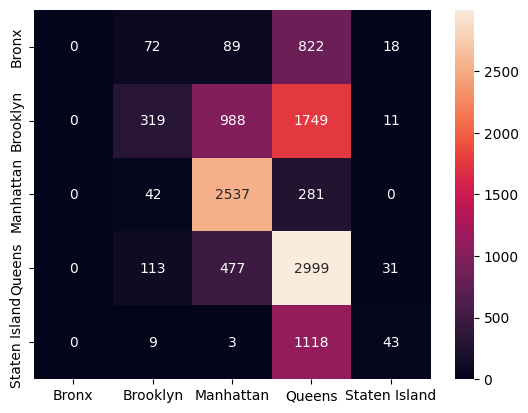

Training the DecisionTreeClassifier() model
======== Reporting =========
train: 0.9911481773777275, test: 0.7483149901885504

Number of predictions by class
Queens           17913
Brooklyn         15216
Manhattan        14487
Staten Island     5814
Bronx             5174
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


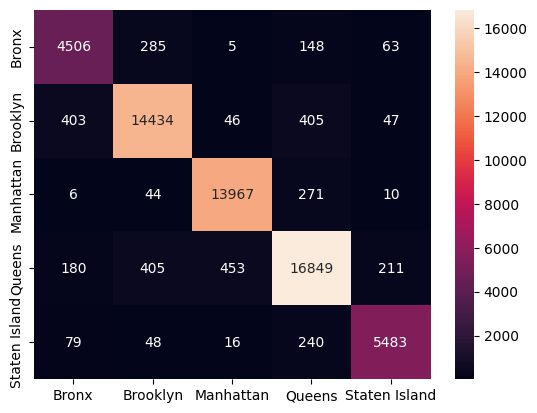


Confusion Matrix (Just training data)


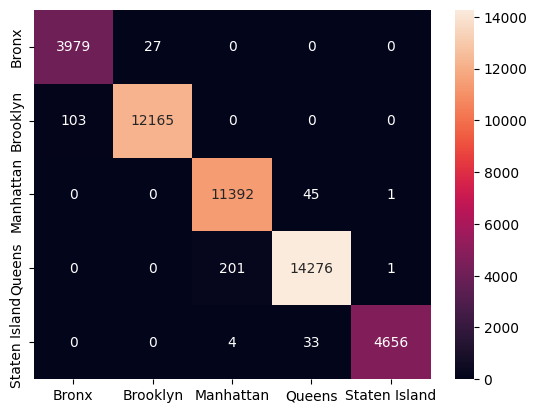


Confusion Matrix (Just test data)


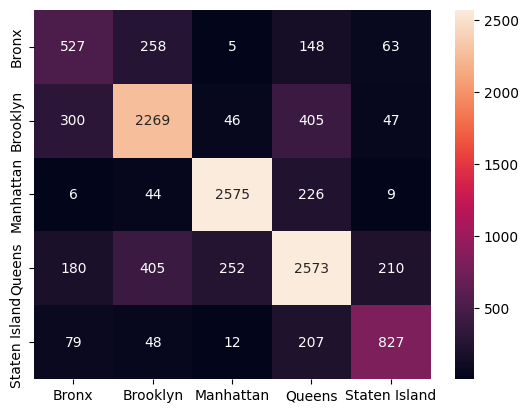

Training the DecisionTreeClassifier(min_samples_leaf=30) model
======== Reporting =========
train: 0.7955548919651046, test: 0.7666581349714188

Number of predictions by class
Queens           18702
Brooklyn         15424
Manhattan        14468
Staten Island     5720
Bronx             4290
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


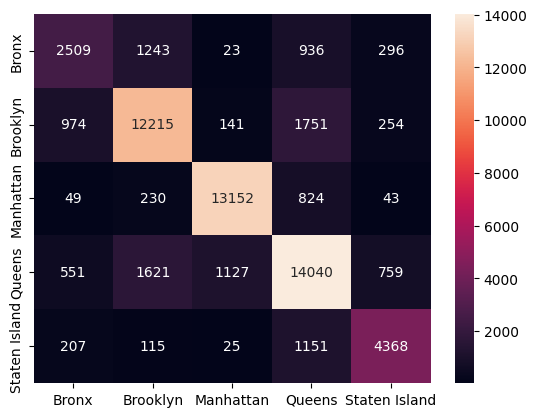


Confusion Matrix (Just training data)


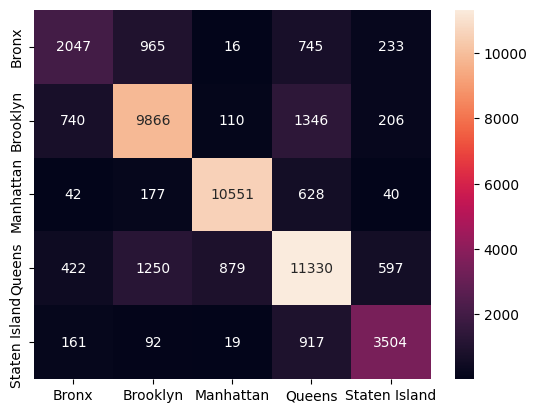


Confusion Matrix (Just test data)


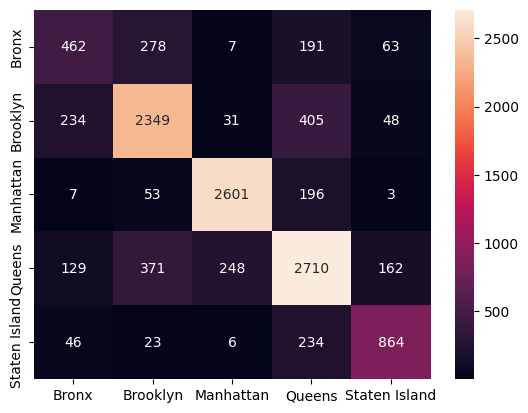

Training the DecisionTreeClassifier(max_depth=10) model
======== Reporting =========
train: 0.7871936522833436, test: 0.7591502431533146

Number of predictions by class
Queens           18618
Brooklyn         15836
Manhattan        14384
Staten Island     5541
Bronx             4225
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


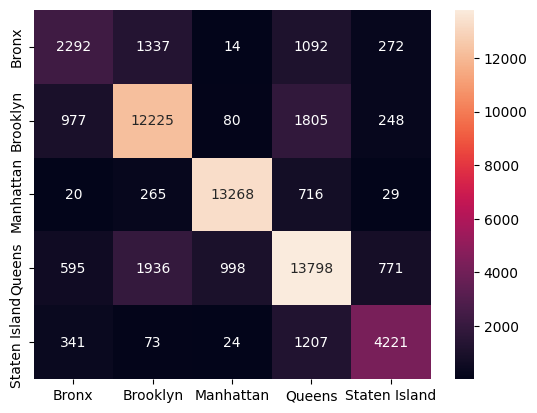


Confusion Matrix (Just training data)


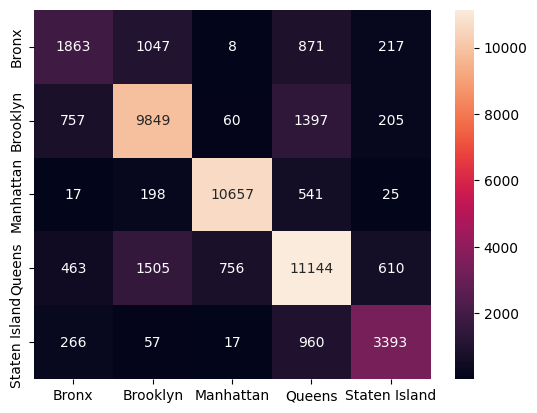


Confusion Matrix (Just test data)


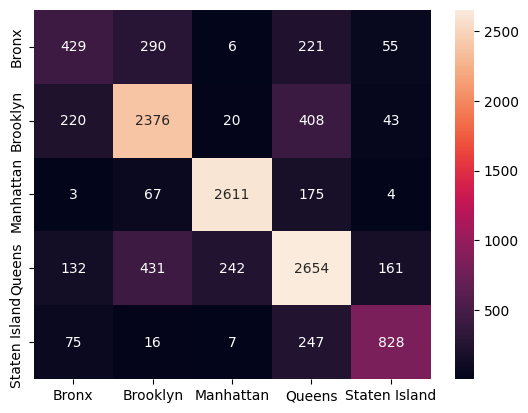

Training the RandomForestClassifier() model
======== Reporting =========
train: 0.9911055179915961, test: 0.7923385376674346

Number of predictions by class
Queens           18279
Brooklyn         15339
Manhattan        14329
Staten Island     5801
Bronx             4856
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


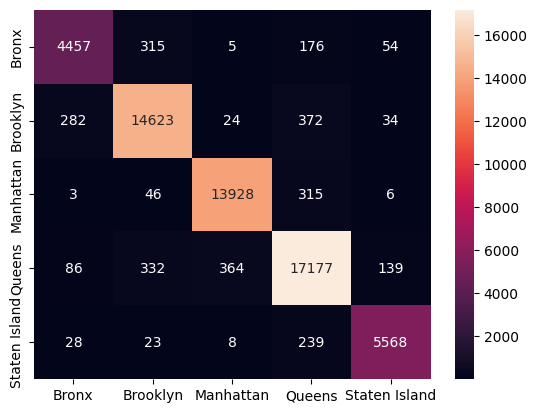


Confusion Matrix (Just training data)


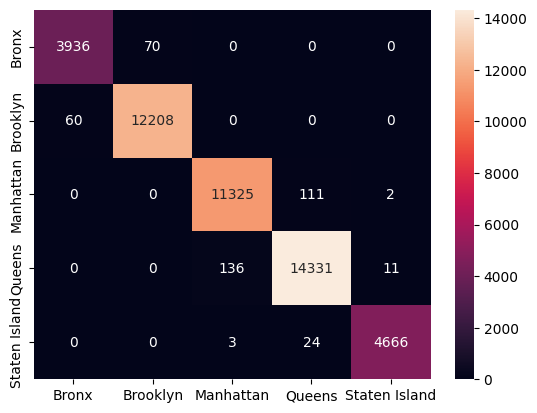


Confusion Matrix (Just test data)


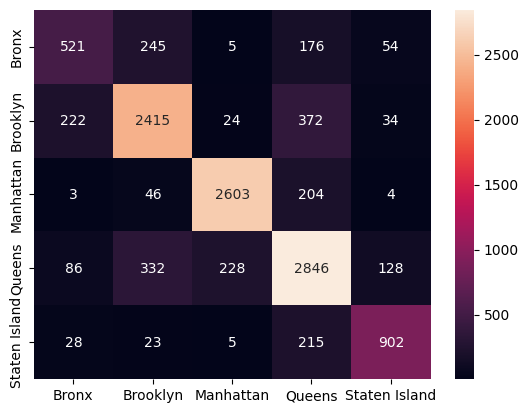

Training the RandomForestClassifier(max_depth=4, n_estimators=200) model
======== Reporting =========
train: 0.6827634750335942, test: 0.6821943520177459

Number of predictions by class
Queens           23717
Brooklyn         16927
Manhattan        15530
Staten Island     2430
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


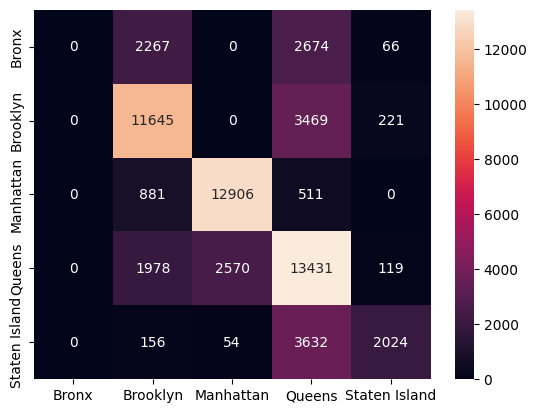


Confusion Matrix (Just training data)


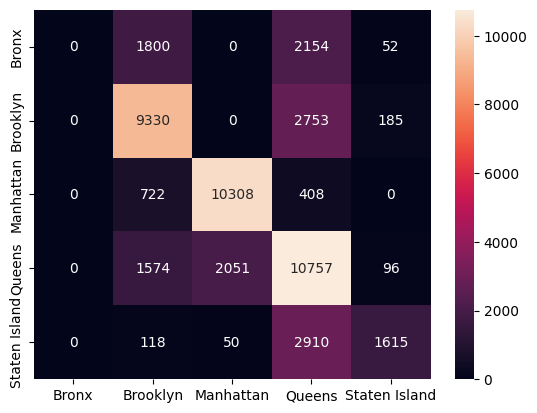


Confusion Matrix (Just test data)


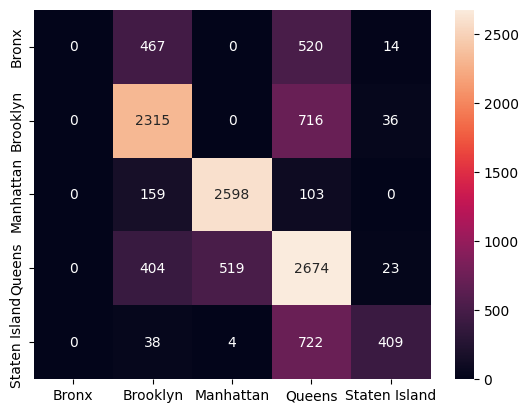

Training the RandomForestClassifier(max_depth=6, n_estimators=200) model
======== Reporting =========
train: 0.7387752490241666, test: 0.7361999829366095

Number of predictions by class
Queens           22368
Brooklyn         16190
Manhattan        15032
Staten Island     4447
Bronx              567
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


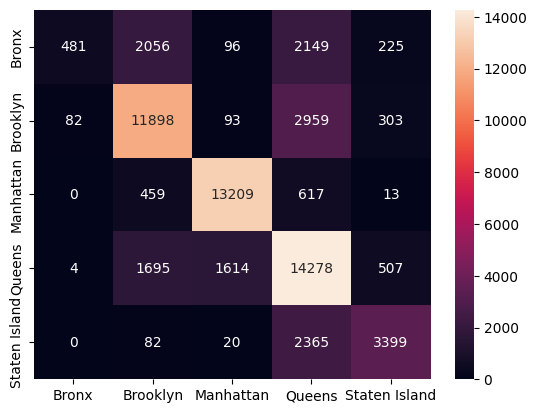


Confusion Matrix (Just training data)


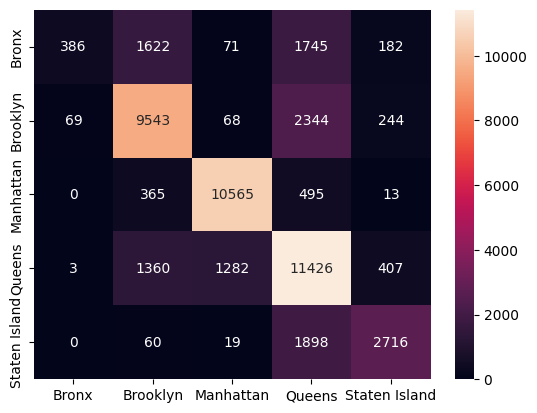


Confusion Matrix (Just test data)


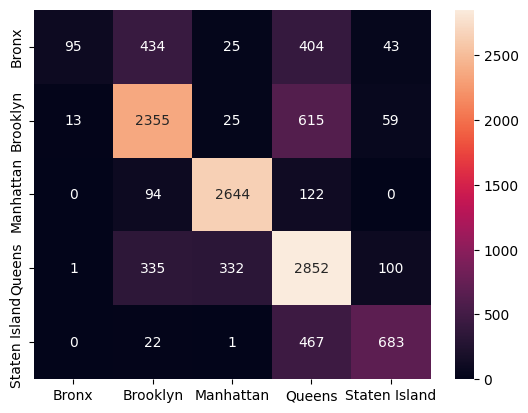

Training the RandomForestClassifier(min_samples_leaf=30, n_estimators=200) model
======== Reporting =========
train: 0.7903504468570697, test: 0.7703267639279925

Number of predictions by class
Queens           19831
Brooklyn         15979
Manhattan        15057
Staten Island     5116
Bronx             2621
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


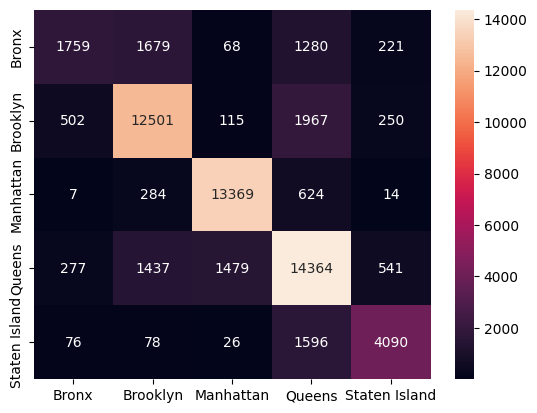


Confusion Matrix (Just training data)


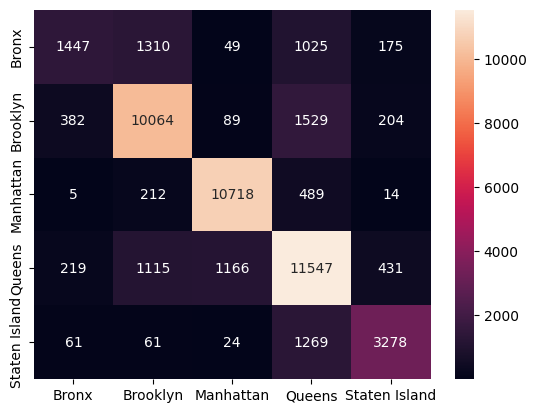


Confusion Matrix (Just test data)


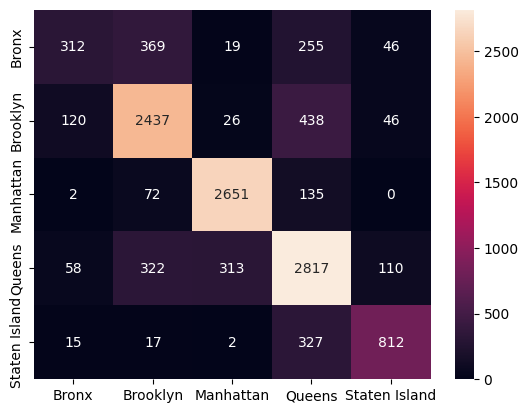

In [10]:
models = [
    LogisticRegression(max_iter=100000),
    LogisticRegression(max_iter=1000, multi_class='ovr'),
    DecisionTreeClassifier(),
    DecisionTreeClassifier(min_samples_leaf=30),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(),
    RandomForestClassifier(n_estimators=200, max_depth=4),
    RandomForestClassifier(n_estimators=200, max_depth=6),
    RandomForestClassifier(n_estimators=200, min_samples_leaf=30)
]

for model in models:
    trained_model = train_and_report(transformed_data, model)

## Next Steps...

In the above results the best individual DecisionTree and the best individual RandomForest performed similarly, that makes me want to do a grid search on both. Cest la vie...

In [16]:
def grid_search_report(tuned_parameters, model_class):
    scoring = {
        'accuracy': make_scorer(accuracy_score),

        'precision_macro': make_scorer(precision_score, average='macro'),
        'precision_weighted': make_scorer(precision_score, average='weighted'),
        
        'recall_macro': make_scorer(recall_score, average='macro'),
        'recall_weighted': make_scorer(recall_score, average='weighted'),

        'f1_macro': make_scorer(f1_score, average='macro'),
        'f1_weighted': make_scorer(f1_score, average='weighted')
    }
    
    labels = transformed_data['BOROUGH']
    features = transformed_data.drop(labels='BOROUGH', axis=1)
    
    # Specifying cv=4 is four-fold but ALSO PERFORMS STRATIFICATION vs the default of None
    # which is important because I know this dataset has class imbalance
    grid_search = GridSearchCV(model_class, tuned_parameters, scoring=scoring, refit=False, cv=4) 
    grid_search.fit(features, labels) 
    
    results = pd.DataFrame({
        
        'accuracy_mean': grid_search.cv_results_['mean_test_accuracy'],
        'accuracy_std': grid_search.cv_results_['std_test_accuracy'],

        'precision_macro_mean': grid_search.cv_results_['mean_test_precision_macro'],
        'precision_macro_std': grid_search.cv_results_['std_test_precision_macro'],
        
        'precision_weighted_mean': grid_search.cv_results_['mean_test_precision_weighted'],
        'precision_weighted_std': grid_search.cv_results_['std_test_precision_weighted'],
        
        'recall_macro_mean': grid_search.cv_results_['mean_test_recall_macro'],
        'recall_macro_std': grid_search.cv_results_['std_test_recall_macro'],
        
        'recall_weighted_mean': grid_search.cv_results_['mean_test_recall_weighted'],
        'recall_weighted_std': grid_search.cv_results_['std_test_recall_weighted'],

        'f1_macro_mean': grid_search.cv_results_['mean_test_f1_macro'],
        'f1_macro_std': grid_search.cv_results_['std_test_f1_macro'],
        
        'f1_weighted_mean': grid_search.cv_results_['mean_test_f1_weighted'],
        'f1_weighted_std': grid_search.cv_results_['std_test_f1_weighted']
    })

    params_df = pd.DataFrame(grid_search.cv_results_['params'], columns=grid_search.cv_results_['params'][0].keys())
    all_results = pd.concat([results, params_df], axis=1)
    
    return grid_search, all_results





In [19]:
tuned_parameters = {
    'criterion': ['gini', 'entropy'], 
    'splitter': ['best', 'random'], 
    'max_depth': [None, 10, 30, 50], 
    'min_samples_split': [2, 50, 100],
    'max_leaf_nodes': [None, 20, 50, 100]
}


gs_object, dt_results = grid_search_report(tuned_parameters, DecisionTreeClassifier())


dt_results.to_csv('decision_grid.csv')
dt_results.sort_values('accuracy_mean', ascending=False).head(50)

/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/tylerbettilyon/tebs-lab-central/courses/data-science-three-day-ws/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

,accuracy_mean,accuracy_std,precision_macro_mean,precision_macro_std,precision_weighted_mean,precision_weighted_std,recall_macro_mean,recall_macro_std,recall_weighted_mean,recall_weighted_std,f1_macro_mean,f1_macro_std,f1_weighted_mean,f1_weighted_std,criterion,max_depth,max_leaf_nodes,min_samples_split,splitter
122,0.718381,0.020693,0.678862,0.019214,0.715115,0.018450,0.668003,0.018862,0.718381,0.020693,0.670523,0.019172,0.714543,0.019792,entropy,10.0,NaN,50,best
170,0.717408,0.020718,0.679866,0.018164,0.717010,0.017956,0.676245,0.019972,0.717408,0.020718,0.676095,0.018198,0.715236,0.019325,entropy,50.0,NaN,50,best
146,0.716999,0.020925,0.679447,0.018306,0.716609,0.018196,0.675844,0.020105,0.716999,0.020925,0.675679,0.018347,0.714820,0.019545,entropy,30.0,NaN,50,best
148,0.716879,0.017866,0.678760,0.017828,0.714867,0.014880,0.671575,0.017090,0.716879,0.017866,0.673057,0.016151,0.714048,0.016269,entropy,30.0,NaN,100,best
120,0.716862,0.019097,0.677089,0.018261,0.713666,0.016959,0.667932,0.017530,0.716862,0.019097,0.669874,0.018163,0.713252,0.018253,entropy,10.0,NaN,2,best
172,0.716862,0.017963,0.678744,0.017920,0.714859,0.014985,0.671592,0.017203,0.716862,0.017963,0.673066,0.016270,0.714039,0.016375,entropy,50.0,NaN,100,best
100,0.716794,0.017888,0.678679,0.017889,0.714807,0.014912,0.671536,0.017140,0.716794,0.017888,0.673005,0.016220,0.713977,0.016302,entropy,NaN,NaN,100,best
98,0.716794,0.020850,0.679382,0.018177,0.716395,0.018156,0.675713,0.020093,0.716794,0.020850,0.675581,0.018283,0.714614,0.019489,entropy,NaN,NaN,50,best
124,0.716299,0.018160,0.676007,0.018430,0.712981,0.016273,0.666196,0.017370,0.716299,0.018160,0.668481,0.017967,0.712639,0.017448,entropy,10.0,NaN,100,best
118,0.713825,0.021347,0.665981,0.023977,0.707344,0.023143,0.663501,0.024234,0.713825,0.021347,0.659530,0.021398,0.707154,0.020542,entropy,NaN,100.0,100,best


## Now the RF

In [23]:
tuned_parameters = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'], 
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 50, 100],
    'max_leaf_nodes': [None, 10, 50, 100], 
    'max_features':['sqrt', 'log2', .8], 
    'n_jobs': [-1]
}


gs_object, rf_results = grid_search_report(tuned_parameters, RandomForestClassifier())
rf_results.to_csv('rf_grid.csv')
rf_results.sort_values('accuracy_mean', ascending=False).head(50)

,accuracy_mean,accuracy_std,precision_macro_mean,precision_macro_std,precision_weighted_mean,precision_weighted_std,recall_macro_mean,recall_macro_std,recall_weighted_mean,recall_weighted_std,...,f1_macro_std,f1_weighted_mean,f1_weighted_std,criterion,max_depth,max_features,max_leaf_nodes,min_samples_split,n_estimators,n_jobs
401,0.737629,0.023455,0.699967,0.025503,0.732910,0.023326,0.686261,0.026834,0.737629,0.023455,...,0.024764,0.732730,0.022992,entropy,NaN,0.8,NaN,50,200,-1
293,0.737492,0.022169,0.701175,0.025460,0.732976,0.022198,0.684860,0.026861,0.737492,0.022169,...,0.024519,0.732503,0.021817,gini,20.0,0.8,NaN,50,200,-1
615,0.737305,0.023447,0.699387,0.025665,0.732421,0.023438,0.684662,0.027007,0.737305,0.023447,...,0.025071,0.732349,0.023076,entropy,20.0,0.8,NaN,50,50,-1
399,0.737066,0.021262,0.699290,0.022974,0.732301,0.020978,0.685185,0.025446,0.737066,0.021262,...,0.022703,0.732125,0.020703,entropy,NaN,0.8,NaN,50,50,-1
77,0.737049,0.021841,0.700794,0.024594,0.732668,0.021554,0.685152,0.025475,0.737049,0.021841,...,0.023279,0.732140,0.021187,gini,NaN,0.8,NaN,50,200,-1
400,0.736980,0.022834,0.699237,0.024911,0.732354,0.022635,0.685493,0.026319,0.736980,0.022834,...,0.024287,0.732190,0.022460,entropy,NaN,0.8,NaN,50,100,-1
616,0.736673,0.022261,0.698971,0.024550,0.731927,0.022163,0.684780,0.025969,0.736673,0.022261,...,0.023947,0.731759,0.021894,entropy,20.0,0.8,NaN,50,100,-1
75,0.736571,0.022771,0.700413,0.023366,0.732069,0.022405,0.684301,0.027271,0.736571,0.022771,...,0.023911,0.731636,0.022332,gini,NaN,0.8,NaN,50,50,-1
76,0.736434,0.022224,0.699473,0.025206,0.731992,0.022127,0.684894,0.026977,0.736434,0.022224,...,0.024524,0.731608,0.021766,gini,NaN,0.8,NaN,50,100,-1
617,0.736366,0.023180,0.699088,0.026034,0.731705,0.023143,0.684804,0.027418,0.736366,0.023180,...,0.025519,0.731484,0.022887,entropy,20.0,0.8,NaN,50,200,-1


# Lets look at the most accurate models performance a little bit more

Training the RandomForestClassifier(criterion='entropy', max_features=0.8,
                       min_samples_split=50, n_estimators=200, n_jobs=-1) model
======== Reporting =========
train: 0.830620907365143, test: 0.7914853681426499

Number of predictions by class
Queens           19276
Brooklyn         15293
Manhattan        14277
Staten Island     5740
Bronx             4018
dtype: int64

Number of true labels by class
Queens           18098
Brooklyn         15335
Manhattan        14298
Staten Island     5866
Bronx             5007
Name: BOROUGH, dtype: int64

Confusion Matrix (all data, not just train or test)


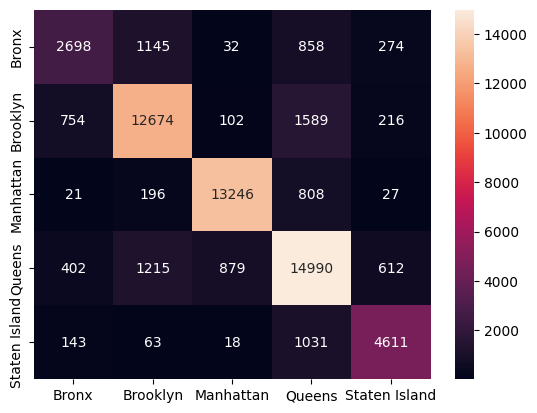


Confusion Matrix (Just training data)


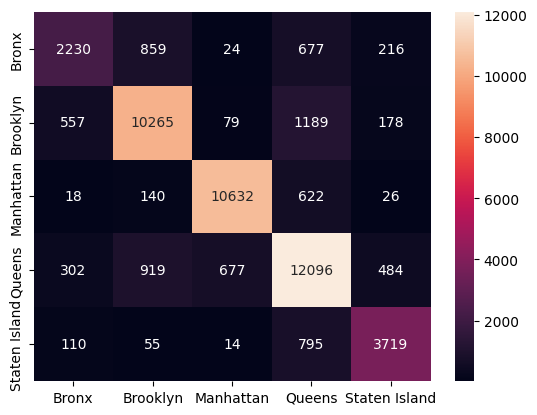


Confusion Matrix (Just test data)


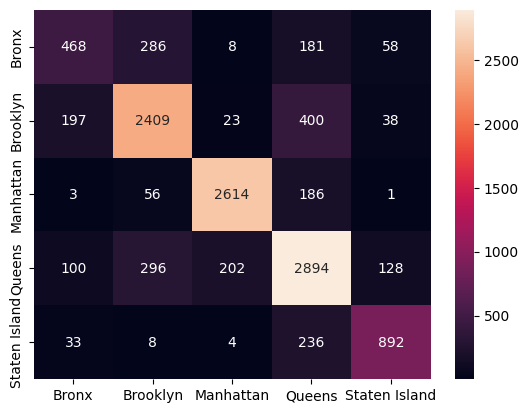

RandomForestClassifier(criterion='entropy', max_features=0.8,
                       min_samples_split=50, n_estimators=200, n_jobs=-1)

In [24]:
model = RandomForestClassifier(criterion='entropy', 
                               max_depth=None, 
                               max_features=.8,
                               max_leaf_nodes=None,
                               min_samples_split=50,
                               n_estimators=200, n_jobs=-1)

train_and_report(transformed_data, model)